In [1]:
# Import all libraries needed for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, randint
import joblib
from sklearn.ensemble import RandomForestRegressor

# Import features.csv and split the 'id' column into 'mutant_id' and 'fitness' columns, keeping the original
features = pd.read_csv("features.csv")
features[['mut_id', 'fitness']] = features['id'].str.split(':', expand=True)
features = features[['id', 'mut_id', 'fitness'] + [col for col in features.columns if col not in ['id', 'mut_id', 'fitness']]]
features['fitness'] = pd.to_numeric(features['fitness'])

In [2]:
# Drop bottom features, as determined by Random Forest Regression feature importance (notebook "2_RFRbiophys_feat_selection"); drop 'loss'
features_top = features.drop(columns=['loss', 'Aromatic', 'NetCharge', 'LumpedHydrophobe', 'Donor', 'NumHeavyAtoms', 'Acceptor', 'NumChargedRes', 'Hydrophobe', 'ProtRDF_all_4.0_5.0'])

# Import mean_pssm_fitness.csv, i.e. MSA data (PSSM average for each sample)
mean_pssm_fitness = pd.read_csv("mean_pssm_fitness.csv")

# Merge with features_top on 'fitness'
features_pssm = pd.merge(features_top, mean_pssm_fitness, on='id', how='inner')

# Drop duplicates (checked to make sure it's the same) and rename _x to original
features_pssm = features_pssm.drop(columns=['fitness_y'])
features_pssm = features_pssm.rename(columns={'fitness_x': 'fitness'})
display(features_pssm)

,id,mut_id,fitness,Volume,MolWt,Hydropathy,NumRotatableBonds,FractionCSP3,Charge,NumPolarRes,NumApolarRes,ProtRDF_all_2.0_3.0,ProtRDF_all_3.0_4.0,RosettaEnergy,fitness_group,mean_pssm
0,K30D:0.5080366134643555,K30D,0.508037,-57.5,-13.087,0.4,-2,-0.333333,-1,6,9,1,-11,-11.954,3,-2.092548
1,D127S:0.619499683380127,D127S,0.619500,-22.1,-28.010,2.7,-1,0.166667,-3,13,14,-1,-12,-1.321,3,-2.090103
2,L114Y:0.9718983173370361,L114Y,0.971898,26.9,50.016,-5.1,0,-0.611111,-1,10,29,-5,-16,3.378,6,-2.095258
3,H83F:0.5161952972412109,H83F,0.516195,36.7,10.035,6.0,0,-0.111111,-2,19,31,8,24,33.264,3,-2.085923
4,R61G:0.7325457334518433,R61G,0.732546,-113.3,-99.137,4.1,-4,-0.166667,3,9,32,-21,-72,-6.110,4,-2.097639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,A15W:0.6964787244796753,A15W,0.696479,139.2,115.135,-2.7,2,-0.484848,4,8,13,9,67,-13.282,4,-2.096031
2850,P28F:0.5048689246177673,P28F,0.504869,77.2,50.060,4.4,2,-0.577778,4,11,20,-1,13,-6.672,3,-2.091682
2851,I112Y:0.28946661949157715,I112Y,0.289467,26.9,50.016,-5.8,0,-0.611111,3,14,31,17,21,111.471,0,-2.086953
2852,P32W:0.9419150352478027,P32W,0.941915,115.1,89.097,0.7,2,-0.618182,1,5,4,-8,23,-13.450,6,-2.091496


In [3]:
# Import PCA-reduced embeddings (512 LVs to 32)
reduced_repr = pd.read_csv("reduced_repr32_flat_df.csv")

# Merge with features_pssm
features_pssm_reduced_repr = pd.merge(reduced_repr, features_pssm, on='id', how='inner')
features_pssm_reduced_repr = features_pssm_reduced_repr.drop(columns={'fitness_y', 'mut_id_y', 'fitness_group_x'})
features_pssm_reduced_repr = features_pssm_reduced_repr.rename(columns={'fitness_x': 'fitness', 'mut_id_x': 'mut_id', 'fitness_group_y': 'fitness_group'})
features_pssm_reduced_repr

,id,mut_id,fitness,0,1,2,3,4,5,6,...,NumRotatableBonds,FractionCSP3,Charge,NumPolarRes,NumApolarRes,ProtRDF_all_2.0_3.0,ProtRDF_all_3.0_4.0,RosettaEnergy,fitness_group,mean_pssm
0,K30D:0.5080366134643555,K30D,0.508037,-2.570003,4.022203,-2.825403,-0.497435,5.511098,1.808109,-3.421183,...,-2,-0.333333,-1,6,9,1,-11,-11.954,3,-2.092548
1,D127S:0.619499683380127,D127S,0.619500,-2.408313,4.189716,-3.005158,-0.643381,5.679404,1.771026,-3.547469,...,-1,0.166667,-3,13,14,-1,-12,-1.321,3,-2.090103
2,L114Y:0.9718983173370361,L114Y,0.971898,-2.414788,4.207225,-2.947061,-0.760829,5.583824,1.845514,-3.586225,...,0,-0.611111,-1,10,29,-5,-16,3.378,6,-2.095258
3,H83F:0.5161952972412109,H83F,0.516195,-2.336842,4.166052,-2.990552,-0.765807,5.636673,1.816508,-3.394135,...,0,-0.111111,-2,19,31,8,24,33.264,3,-2.085923
4,R61G:0.7325457334518433,R61G,0.732546,-2.350058,4.131976,-3.005839,-0.800218,5.611013,1.724892,-3.542427,...,-4,-0.166667,3,9,32,-21,-72,-6.110,4,-2.097639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,A15W:0.6964787244796753,A15W,0.696479,-2.367344,4.253077,-3.006349,-0.796674,5.611206,1.773938,-3.572023,...,2,-0.484848,4,8,13,9,67,-13.282,4,-2.096031
2850,P28F:0.5048689246177673,P28F,0.504869,-2.355089,4.190887,-2.925232,-0.709169,5.654644,1.774303,-3.631063,...,2,-0.577778,4,11,20,-1,13,-6.672,3,-2.091682
2851,I112Y:0.28946661949157715,I112Y,0.289467,-2.360195,4.133191,-2.966794,-0.757661,5.583155,1.817814,-3.496653,...,0,-0.611111,3,14,31,17,21,111.471,0,-2.086953
2852,P32W:0.9419150352478027,P32W,0.941915,-2.400716,4.281382,-2.914210,-0.778232,5.618531,1.781330,-3.476890,...,2,-0.618182,1,5,4,-8,23,-13.450,6,-2.091496


In [4]:
# Create polynomial features to capture non-linear relationships
X = features_pssm_reduced_repr.drop(columns=['id', 'mut_id', 'fitness', 'fitness_group']) 
y = features_pssm_reduced_repr['fitness']

# Polynomial scaling
X_squared = pd.DataFrame()

# Square the features and add them to the new DataFrame
squared_features = {f'{col}_squared': X[col] ** 2 for col in X.columns}
X_squared = pd.concat([X_squared, pd.DataFrame(squared_features)], axis=1)
X_squared

,0_squared,1_squared,2_squared,3_squared,4_squared,5_squared,6_squared,7_squared,8_squared,9_squared,...,Hydropathy_squared,NumRotatableBonds_squared,FractionCSP3_squared,Charge_squared,NumPolarRes_squared,NumApolarRes_squared,ProtRDF_all_2.0_3.0_squared,ProtRDF_all_3.0_4.0_squared,RosettaEnergy_squared,mean_pssm_squared
0,6.604917,16.178117,7.982900,0.247442,30.372201,3.269259,11.704495,31.831047,0.215235,12.148990,...,0.16,4,0.111111,1,36,81,1,121,142.898116,4.378758
1,5.799971,17.553720,9.030973,0.413939,32.255630,3.136534,12.584537,30.756444,0.102463,12.960866,...,7.29,1,0.027778,9,169,196,1,144,1.745041,4.368531
2,5.831199,17.700745,8.685169,0.578861,31.179090,3.405922,12.861008,30.527117,0.119565,13.211214,...,26.01,0,0.373457,1,100,841,25,256,11.410884,4.390106
3,5.460830,17.355992,8.943402,0.586461,31.772077,3.299700,11.520154,29.928728,0.143930,13.037427,...,36.00,0,0.012346,4,361,961,64,576,1106.493696,4.351073
4,5.522772,17.073226,9.035068,0.640348,31.483467,2.975252,12.548788,30.541367,0.107308,13.417902,...,16.81,16,0.027778,9,81,1024,441,5184,37.332100,4.400089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,5.604318,18.088664,9.038136,0.634689,31.485633,3.146857,12.759346,30.364233,0.122107,13.823952,...,7.29,4,0.235078,16,64,169,81,4489,176.411524,4.393347
2850,5.546445,17.563538,8.556980,0.502921,31.975004,3.148151,13.184619,31.061868,0.101522,13.373951,...,19.36,4,0.333827,16,121,400,1,169,44.515584,4.375135
2851,5.570520,17.083268,8.801868,0.574050,31.171616,3.304449,12.226584,31.024179,0.146979,12.992553,...,33.64,0,0.373457,9,196,961,289,441,12425.783841,4.355373
2852,5.763436,18.330232,8.492618,0.605645,31.567891,3.173135,12.088761,29.954189,0.070331,13.120956,...,0.49,4,0.382149,1,25,16,64,529,180.902500,4.374354


In [5]:
### FINAL Ridge regression ###

# Scaling
minmaxscaler = MinMaxScaler()
scaler = StandardScaler()
X_squared_minmax = minmaxscaler.fit_transform(X_squared)
X_squared_scaled = scaler.fit_transform(X_squared) 

# Sample 96 samples, in a stratified manner, based on fitness_group
X_train, X_test, y_train, y_test = train_test_split(X_squared_minmax, y, train_size=96, stratify=features_pssm_reduced_repr['fitness_group'], random_state=42)

# Define a range of alphas for cross-validation
alphas = np.logspace(-6, 6, 13)  
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Predict the fitness for the test set
y_pred_ridge = ridge_cv.predict(X_test)

# Print the best alpha and model performance
print(f"Best alpha: {ridge_cv.alpha_}")
print(f"Training Score: {ridge_cv.score(X_train, y_train)}")
print(f"Test Score: {ridge_cv.score(X_test, y_test)}")

# Predict and evaluate the model
mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred_ridge)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred_ridge)
print(f"Mean Absolute Error: {mae}")
# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred_ridge)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

Best alpha: 10.0
Training Score: 0.7004602157445403
Test Score: 0.17380995903676044
Mean Squared Error: 0.10416650976428654
R2 score: 0.17380995903676044
Mean Absolute Error: 0.2471410077831552
Spearman's correlation: 0.5082682212343106
Spearman's p-value: 4.1712452211352486e-181


In [26]:
# Save the model to a file
#ridge_cv_joblib = "Ridge_regr.pkl"
#joblib.dump(ridge_cv, ridge_cv_joblib)

['Ridge_regr.pkl']

In [6]:
# load the pkl file to test
ridge_cv_joblib = "Ridge_regr.pkl"
ridge_loaded = joblib.load(ridge_cv_joblib)

prediction = ridge_loaded.predict(X_test)

# Predict and evaluate the model
mse = mean_squared_error(y_test, prediction)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, prediction)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, prediction)
print(f"Mean Absolute Error: {mae}")
# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, prediction)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

Mean Squared Error: 0.10418004624566342
R2 score: 0.17370259529645105
Mean Absolute Error: 0.24684341958903946
Spearman's correlation: 0.5082944490148699
Spearman's p-value: 3.969437133947556e-181


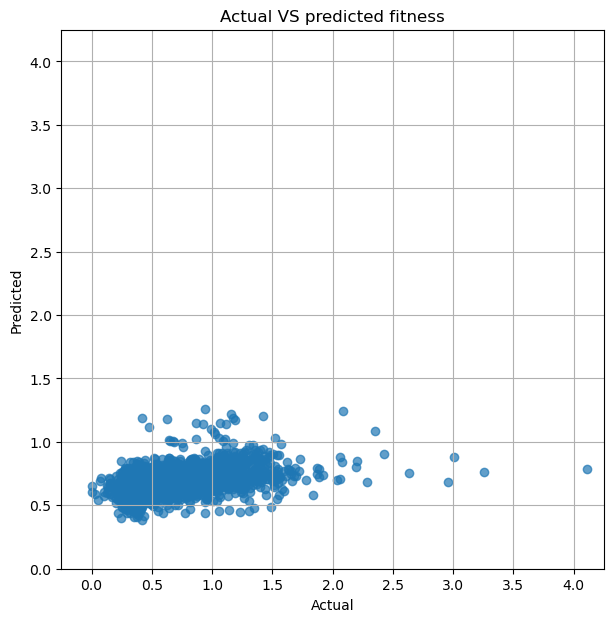

In [7]:
# Plot actual fitness against predicted fitness
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_ridge, alpha=0.7)
plt.xlim(-0.25, 4.25)
plt.ylim(0, 4.25)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual VS predicted fitness')
plt.grid(True)
plt.gca().set_aspect(aspect='auto', adjustable='datalim')
plt.show()

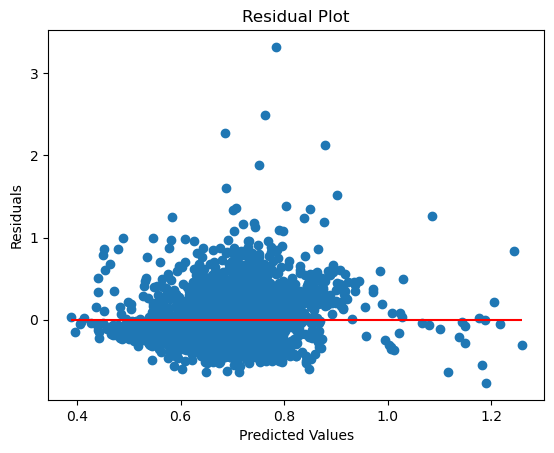

In [8]:
# Plot residuals
residuals_ridge = y_test - y_pred_ridge

plt.scatter(y_pred_ridge, residuals_ridge)
plt.hlines(0, xmin=min(y_pred_ridge), xmax=max(y_pred_ridge), colors='r')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [9]:
# Try RFR 

# Use train_test_split with the stratify parameter
X_train, X_test, y_train, y_test = train_test_split(X_squared, y, train_size=96, stratify=features_pssm_reduced_repr['fitness_group'], random_state=42)

# Train the rfr with optimised features (from last two cells)
rfr = RandomForestRegressor(min_samples_split=5, min_samples_leaf=1, max_depth=30, random_state=42)
rfr.fit(X_train, y_train)

# Predict the fitness scores for the test set
y_pred = rfr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

Mean Squared Error: 0.11296659682245574
R2 score: 0.1040126287477735
Mean Absolute Error: 0.2649767097931339
Spearman's correlation: 0.3350827147135697
Spearman's p-value: 2.395631629317167e-73


In [35]:
### Try to optimise rfr
# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
}

# Initialize RandomizedSearchCV
#random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_dist, n_iter=30, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

In [36]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", -random_search.best_score_)

Best parameters found:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30}
Best cross-validation score:  0.10065253103368668
